In [1]:
%%html
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
.success { color: green; font-weight: bold; }
.error { color: red; font-weight: bold; }
.warning { color: orange; font-weight: bold; }
</style>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy.fftpack import dct, idct
import pywt
# Use scipy.stats.pearsonr for correlation, a common similarity measure for vectors
from scipy.stats import pearsonr
import warnings
import ipywidgets as widgets
from IPython.display import display, clear_output
import json
import datetime
import hashlib
import os
from io import BytesIO
import base64

warnings.filterwarnings('ignore')

print("🔍 Enhanced DWT+DCT+SVD Watermarking System with Copyright Management")

🔍 Enhanced DWT+DCT+SVD Watermarking System with Copyright Management


In [3]:
class FixedWatermarkingSystem:
    def __init__(self, wavelet='haar', block_size=8, base_alpha=0.1):
        """
        Fixed watermarking system comparing singular values (additive embedding).
        """
        self.wavelet = wavelet
        self.block_size = block_size
        self.base_alpha = base_alpha
        self.database = {}
        self.verification_log = []

    # --- generate_copyright_info, text_to_watermark, preprocess_image, calculate_complexity, adaptive_alpha remain the same ---
    def generate_copyright_info(self, owner_name, contact_info, rights="All rights reserved"):
        """Generate copyright information"""
        timestamp = datetime.datetime.now().isoformat()
        copyright_id = hashlib.md5(f"{owner_name}{timestamp}".encode()).hexdigest()[:16]

        return {
            'copyright_id': copyright_id,
            'owner_name': owner_name,
            'contact_info': contact_info,
            'rights': rights,
            'timestamp': timestamp,
            'registration_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

    def text_to_watermark(self, text, size=(64, 64)):
        """Convert text to binary watermark pattern"""
        watermark = np.zeros(size, dtype=np.float64)
        text_binary = ''.join(format(ord(c), '08b') for c in text)

        height, width = size
        max_bits = height * width

        if len(text_binary) > max_bits:
            print(f"   ⚠️ Warning: Copyright text too long, truncated to {max_bits} bits.")
            text_binary = text_binary[:max_bits]

        for i, bit in enumerate(text_binary):
             if i < max_bits:
                row = i // width
                col = i % width
                watermark[row, col] = float(bit)

        return watermark

    def preprocess_image(self, image_path, target_size=(512, 512)):
        """Preprocess image for watermarking"""
        try:
            if isinstance(image_path, str):
                img = Image.open(image_path).convert('L')
            elif hasattr(image_path, 'read'):
                img = Image.open(image_path).convert('L')
            else:
                 raise ValueError("Invalid image_path type")

            img = np.array(img)
            if img.shape != target_size:
                 img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

            if img.dtype != np.float64:
                 img = img.astype(np.float64)
            if img.max() > 1.0:
                 img = img / 255.0

            return np.clip(img, 0.0, 1.0)
        except Exception as e:
            print(f"   ❌ Error preprocessing image {image_path}: {e}")
            raise

    def calculate_complexity(self, image):
        """Calculate image complexity using edge density"""
        img_uint8 = (np.clip(image, 0, 1) * 255).astype(np.uint8)
        edges = cv2.Canny(img_uint8, 50, 150)
        return np.sum(edges > 0) / edges.size

    def adaptive_alpha(self, complexity):
        """Adaptive watermark strength, ensuring it stays within a reasonable range"""
        alpha = self.base_alpha * (1 + complexity * 1.5)
        return np.clip(alpha, 0.01, 0.2)

    # --- embed_watermark Updated ---
    def embed_watermark(self, host_image, watermark_pattern, alpha):
        """
        Embed watermark pattern using DWT + DCT + SVD (Additive).
        Stores host's original S_h and watermark's S_w.
        """
        print("   🔧 Embedding watermark...")

        coeffs_h = pywt.wavedec2(host_image, self.wavelet, level=1)
        LL_h, (HL_h, LH_h, HH_h) = coeffs_h

        wm_resized = cv2.resize(watermark_pattern, LL_h.shape[::-1], interpolation=cv2.INTER_NEAREST)
        coeffs_w = pywt.wavedec2(wm_resized, self.wavelet, level=1)
        LL_w, (HL_w, LH_w, HH_w) = coeffs_w

        LL_h_dct = self.block_dct(LL_h)

        try:
            U_h, S_h_original, Vt_h = np.linalg.svd(LL_h_dct, full_matrices=False)
        except np.linalg.LinAlgError:
            print("   ⚠️ SVD did not converge on host DCT block during embedding. Adding small noise.")
            LL_h_dct += np.random.normal(0, 1e-10, LL_h_dct.shape)
            U_h, S_h_original, Vt_h = np.linalg.svd(LL_h_dct, full_matrices=False)

        try:
            U_w, S_w_original, Vt_w = np.linalg.svd(LL_w, full_matrices=False)
        except np.linalg.LinAlgError:
             print("   ⚠️ SVD did not converge on watermark LL subband during embedding. Adding small noise.")
             LL_w += np.random.normal(0, 1e-10, LL_w.shape)
             U_w, S_w_original, Vt_w = np.linalg.svd(LL_w, full_matrices=False)

        min_len = min(len(S_h_original), len(S_w_original))
        S_embedded = S_h_original.copy()
        # *** Use Additive Embedding ***
        S_embedded[:min_len] = S_h_original[:min_len] + alpha * S_w_original[:min_len]

        S_embedded_diag = np.zeros(LL_h_dct.shape, dtype=float)
        np.fill_diagonal(S_embedded_diag, S_embedded)
        U_h_use = U_h[:, :len(S_embedded)]
        Vt_h_use = Vt_h[:len(S_embedded), :]
        LL_h_dct_embedded = U_h_use @ S_embedded_diag[:len(S_embedded), :len(S_embedded)] @ Vt_h_use

        LL_h_embedded = self.inverse_block_dct(LL_h_dct_embedded)

        coeffs_embedded = [LL_h_embedded, (HL_h, LH_h, HH_h)]
        watermarked = pywt.waverec2(coeffs_embedded, self.wavelet)
        watermarked = np.clip(watermarked, 0, 1)

        extraction_data = {
            'S_h_original': S_h_original[:min_len],
            'S_w_original': S_w_original[:min_len],
            'alpha': alpha,
            'min_len': min_len,
            'wavelet': self.wavelet,
            'original_wm_pattern_shape': watermark_pattern.shape
        }

        return watermarked, extraction_data

    # --- extract_watermark Updated ---
    def extract_watermark(self, test_image, extraction_data):
        """
        Extract watermark singular values using additive inverse.
        Returns the extracted singular values (S_extracted).
        """
        try:
            coeffs_t = pywt.wavedec2(test_image, extraction_data['wavelet'], level=1)
            LL_t, _ = coeffs_t

            LL_t_dct = self.block_dct(LL_t)

            try:
                U_t, S_t, Vt_t = np.linalg.svd(LL_t_dct, full_matrices=False)
            except np.linalg.LinAlgError:
                 print("   ⚠️ SVD did not converge during extraction. Result might be inaccurate.")
                 return None

            S_h_original = extraction_data['S_h_original']
            alpha = extraction_data['alpha']
            min_len = extraction_data['min_len']

            len_S_t = len(S_t)
            if len_S_t < min_len:
                 print(f"   ⚠️ Warning: Extracted S_t length ({len_S_t}) < min_len ({min_len}). Padding.")
                 S_t_padded = np.pad(S_t, (0, min_len - len_S_t))
                 S_t_use = S_t_padded[:min_len]
            else:
                 S_t_use = S_t[:min_len]

            # *** Use Additive Extraction ***
            # Handle potential division by zero for alpha (though clip in adaptive_alpha should prevent it)
            alpha_safe = alpha if alpha != 0 else 1e-10
            S_extracted = (S_t_use - S_h_original) / alpha_safe
            S_extracted = np.nan_to_num(S_extracted)

            return S_extracted

        except Exception as e:
            print(f"   ❌ Extraction error: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    # --- block_dct, inverse_block_dct remain the same ---
    def block_dct(self, subband):
        """Apply block-based DCT"""
        h, w = subband.shape
        dct_blocks = np.zeros_like(subband)
        pad_h = (self.block_size - h % self.block_size) % self.block_size
        pad_w = (self.block_size - w % self.block_size) % self.block_size
        subband_padded = np.pad(subband, ((0, pad_h), (0, pad_w)), mode='constant')
        hp, wp = subband_padded.shape

        for i in range(0, hp, self.block_size):
            for j in range(0, wp, self.block_size):
                block = subband_padded[i:i+self.block_size, j:j+self.block_size]
                # Check block shape just in case padding logic failed
                if block.shape == (self.block_size, self.block_size):
                    dct_blocks[i:i+self.block_size, j:j+self.block_size] = dct(dct(block.T, norm='ortho').T, norm='ortho')
                # else: # This else should ideally not be needed with correct padding
                #    print(f"   Warning: Skipping DCT for block at ({i},{j}) with shape {block.shape}")


        return dct_blocks[:h, :w] # Return original size

    def inverse_block_dct(self, dct_blocks):
        """Apply inverse block-based DCT"""
        h, w = dct_blocks.shape
        idct_blocks = np.zeros_like(dct_blocks)
        pad_h = (self.block_size - h % self.block_size) % self.block_size
        pad_w = (self.block_size - w % self.block_size) % self.block_size
        dct_blocks_padded = np.pad(dct_blocks, ((0, pad_h), (0, pad_w)), mode='constant')
        hp, wp = dct_blocks_padded.shape

        for i in range(0, hp, self.block_size):
            for j in range(0, wp, self.block_size):
                block = dct_blocks_padded[i:i+self.block_size, j:j+self.block_size]
                if block.shape == (self.block_size, self.block_size):
                    idct_blocks[i:i+self.block_size, j:j+self.block_size] = idct(idct(block.T, norm='ortho').T, norm='ortho')
                # else: # This else should ideally not be needed
                #    print(f"   Warning: Skipping IDCT for block at ({i},{j}) with shape {block.shape}")


        return idct_blocks[:h, :w] # Return original size


    # --- register_copyright remains the same ---
    def register_copyright(self, image_path, owner_name, contact_info, rights="All rights reserved"):
        """Register copyright and embed watermark"""
        print("📝 Starting copyright registration...")
        copyright_info = self.generate_copyright_info(owner_name, contact_info, rights)

        timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        copyright_text = f"COPYRIGHT:{copyright_info['copyright_id']}:{owner_name}:{timestamp}"
        watermark_pattern = self.text_to_watermark(copyright_text)

        try:
             host_image = self.preprocess_image(image_path)
        except Exception as e:
             print(f"   ❌ Failed to register: {e}")
             return None, None

        complexity = self.calculate_complexity(host_image)
        alpha = self.adaptive_alpha(complexity)

        print(f"📊 Image Analysis:")
        print(f"   Complexity: {complexity:.4f}")
        print(f"   Adaptive Alpha: {alpha:.4f}")

        watermarked_image, extraction_data = self.embed_watermark(host_image, watermark_pattern, alpha)

        self.database[copyright_info['copyright_id']] = {
            'copyright_info': copyright_info,
            'extraction_data': extraction_data,
            'original_host_shape': host_image.shape,
        }

        print("✅ Copyright registration completed!")
        print(f"📄 Copyright ID: {copyright_info['copyright_id']}")

        return watermarked_image, copyright_info

    # --- verify_authenticity remains the same (uses updated calculate_similarity and generate_report) ---
    def verify_authenticity(self, image_path, expected_owner=None):
        """
        Verify image authenticity by comparing extracted singular values
        with stored original watermark singular values.
        """
        print("🔍 Starting authenticity verification...")

        try:
            test_image = self.preprocess_image(image_path)
        except Exception as e:
            print(f"   ❌ Verification failed: Could not process test image - {e}")
            report = self.generate_verification_report(None, 0, expected_owner, status_override="ERROR")
            self.log_verification(image_path, report)
            return report, None, None

        best_match_info = None
        best_similarity = -1

        if not self.database:
             print("   ⚠️ Database is empty. Cannot verify.")
             report = self.generate_verification_report(None, 0, expected_owner, status_override="DB_EMPTY")
             self.log_verification(image_path, report)
             return report, None, None

        for copyright_id, data in self.database.items():
            try:
                if 'extraction_data' not in data:
                    print(f"   ⚠️ Missing extraction data for {copyright_id}. Skipping.")
                    continue

                extracted_sv = self.extract_watermark(test_image, data['extraction_data'])

                if extracted_sv is not None:
                    original_sv = data['extraction_data']['S_w_original']
                    similarity = self.calculate_similarity(original_sv, extracted_sv)
                    print(f"   🔍 Testing against {copyright_id}: Similarity (Correlation) = {similarity:.4f}")

                    if similarity > best_similarity:
                        best_similarity = similarity
                        best_match_info = data['copyright_info']
                else:
                    print(f"   ❌ Extraction failed for {copyright_id}")

            except KeyError as e:
                print(f"   ⚠️ Data format error for {copyright_id}: Missing key {e}. Skipping.")
                continue
            except Exception as e:
                print(f"   ⚠️ Error during verification against {copyright_id}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue

        report = self.generate_verification_report(best_match_info, best_similarity, expected_owner)
        self.log_verification(image_path, report)
        return report, best_match_info, None

    # --- calculate_similarity remains the same ---
    def calculate_similarity(self, sv_original, sv_extracted):
        """
        Calculate similarity between original and extracted singular value vectors
        using Pearson Correlation Coefficient.
        """
        if sv_extracted is None:
            return 0.0

        len_orig = len(sv_original)
        len_extr = len(sv_extracted)

        if len_orig == 0 or len_extr == 0:
             return 0.0

        compare_len = min(len_orig, len_extr)
        if compare_len < len_orig or compare_len < len_extr:
            print(f"   ⚠️ Warning: SV vector lengths differ ({len_orig} vs {len_extr}). Comparing first {compare_len} values.")

        vec1 = sv_original[:compare_len]
        vec2 = sv_extracted[:compare_len]

        if np.std(vec1) == 0 or np.std(vec2) == 0:
             if np.allclose(vec1, vec2):
                 return 1.0
             else:
                 return 0.0

        try:
            correlation, _ = pearsonr(vec1, vec2)
            return np.nan_to_num(correlation)
        except ValueError as e:
             print(f"   ⚠️ Error calculating correlation: {e}")
             return 0.0

    # --- generate_verification_report Updated Threshold ---
    def generate_verification_report(self, copyright_info, similarity, expected_owner, status_override=None):
        """Generate verification report based on correlation score"""
        report = {
            'timestamp': datetime.datetime.now().isoformat(),
            'similarity_score': similarity,
            'expected_owner_match': False
        }

        # *** Adjust Auth Threshold ***
        auth_threshold = 0.75 # Lowered threshold slightly

        if status_override:
             report['authentication_status'] = status_override
             report['confidence_level'] = "N/A"
        elif similarity >= auth_threshold:
             report['authentication_status'] = 'AUTHENTIC'
             report['confidence_level'] = self.get_confidence_level(similarity)
        else:
             report['authentication_status'] = 'SUSPICIOUS'
             report['confidence_level'] = self.get_confidence_level(similarity)

        if copyright_info:
            report.update({
                'copyright_id': copyright_info['copyright_id'],
                'registered_owner': copyright_info['owner_name'],
                'registration_date': copyright_info['registration_date']
            })
            if expected_owner and expected_owner.lower() in copyright_info['owner_name'].lower():
                report['expected_owner_match'] = True
        elif report['authentication_status'] not in ["ERROR", "DB_EMPTY"]:
             report['message'] = "No matching copyright found in database."

        return report

    # --- get_confidence_level Updated Thresholds ---
    def get_confidence_level(self, similarity):
        """Get confidence level based on correlation score"""
        if similarity >= 0.9: return "VERY HIGH"
        elif similarity >= 0.75: return "HIGH" # Adjusted
        elif similarity >= 0.60: return "MEDIUM" # Adjusted
        elif similarity >= 0.45: return "LOW"    # Adjusted
        else: return "VERY LOW"

    # --- log_verification, display_verification_report, display_database, display_verification_log remain the same ---
    def log_verification(self, image_path, report):
        """Log verification attempt"""
        self.verification_log.append({
            'image_path': str(image_path),
            'timestamp': report['timestamp'],
            'status': report['authentication_status'],
            'similarity': report['similarity_score'],
            'confidence': report['confidence_level'],
            'copyright_id': report.get('copyright_id', 'N/A'),
            'owner_match': report.get('expected_owner_match', 'N/A')
        })

    def display_verification_report(self, report):
        """Display verification report"""
        print("\n" + "="*70)
        print("🔍 AUTHENTICITY VERIFICATION REPORT")
        print("="*70)
        status_icon = "✅" if report['authentication_status'] == 'AUTHENTIC' else "❌"
        print(f"🕒 Time: {report['timestamp']}")
        print(f"📊 Similarity (Correlation): {report['similarity_score']:.4f}")
        print(f"🎯 Confidence: {report['confidence_level']}")
        print(f"🔐 Status: {status_icon} {report['authentication_status']}")
        if 'copyright_id' in report:
            print(f"📄 Copyright ID Found: {report['copyright_id']}")
            print(f"👤 Registered Owner: {report['registered_owner']}")
            owner_match_status = 'CONFIRMED' if report['expected_owner_match'] else 'NOT MATCHED'
            print(f"👤 Expected Owner Match: {owner_match_status}")
        elif report['authentication_status'] not in ["ERROR", "DB_EMPTY"]:
            print("❌ No valid copyright match found in the database.")
        elif 'message' in report:
             print(f"ℹ️ Message: {report['message']}")
        print("="*70)

    def display_database(self):
        """Display database summary"""
        print("\n" + "="*50)
        print("📊 COPYRIGHT DATABASE")
        print("="*50)
        if not self.database:
            print("   Database is empty.")
        else:
            for i, (copyright_id, data) in enumerate(self.database.items()):
                info = data.get('copyright_info', {})
                owner = info.get('owner_name', 'N/A')
                reg_date = info.get('registration_date', 'N/A')
                print(f"   {i+1}. ID: {copyright_id}")
                print(f"      👤 Owner: {owner}")
                print(f"      📅 Registered: {reg_date}")
                if i < len(self.database) - 1:
                     print("   " + "-"*40)
        print("="*50)

    def display_verification_log(self):
         """Display the verification log"""
         print("\n" + "="*70)
         print("📜 AUTHENTICITY VERIFICATION LOG")
         print("="*70)
         if not self.verification_log:
             print("   Log is empty.")
         else:
             for i, entry in enumerate(self.verification_log):
                 print(f"   {i+1}. Timestamp: {entry['timestamp']}")
                 path_display = entry['image_path']
                 if len(path_display) > 50:
                     path_display = "..." + path_display[-47:]
                 print(f"      🖼️ Image: {path_display}")
                 print(f"      🔐 Status: {entry['status']}")
                 print(f"      📊 Similarity: {entry['similarity']:.4f}")
                 print(f"      🎯 Confidence: {entry['confidence']}")
                 print(f"      📄 Found ID: {entry['copyright_id']}")
                 print(f"      👤 Owner Match: {entry['owner_match']}")
                 if i < len(self.verification_log) - 1:
                     print("   " + "-"*60)
         print("="*70)

🖼️ Creating test images...


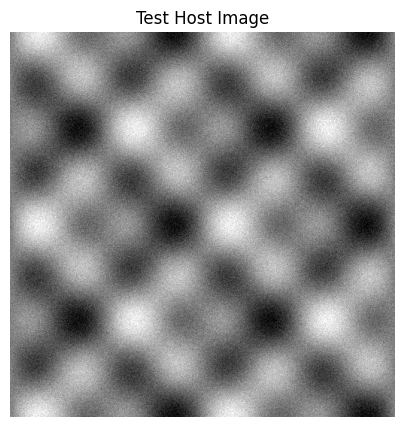

In [4]:
def create_test_images():
    """Create proper test images"""
    print("🖼️ Creating test images...")

    # Create distinct host image
    x, y = np.meshgrid(np.linspace(0, 4*np.pi, 512), np.linspace(0, 4*np.pi, 512))
    host = (np.sin(x) * np.cos(y) + np.sin(2*x) * np.cos(2*y) + 2) / 4

    # Add realistic noise
    host += np.random.normal(0, 0.05, host.shape)
    host = np.clip(host, 0, 1)

    # Save host image (no watermark needed to be saved separately for testing)
    Image.fromarray((host * 255).astype(np.uint8)).save('test_host.jpg')

    # Display host image
    plt.figure(figsize=(5, 5)) # Adjusted size as only one image needed here
    plt.imshow(host, cmap='gray')
    plt.title('Test Host Image')
    plt.axis('off')
    plt.show()

    return 'test_host.jpg' # Only return host path

host_path = create_test_images()


🎯 COMPREHENSIVE SYSTEM TEST

1. 📝 REGISTER COPYRIGHT
📝 Starting copyright registration...
📊 Image Analysis:
   Complexity: 0.3174
   Adaptive Alpha: 0.2000
   🔧 Embedding watermark...
✅ Copyright registration completed!
📄 Copyright ID: 64b839f0ab953949


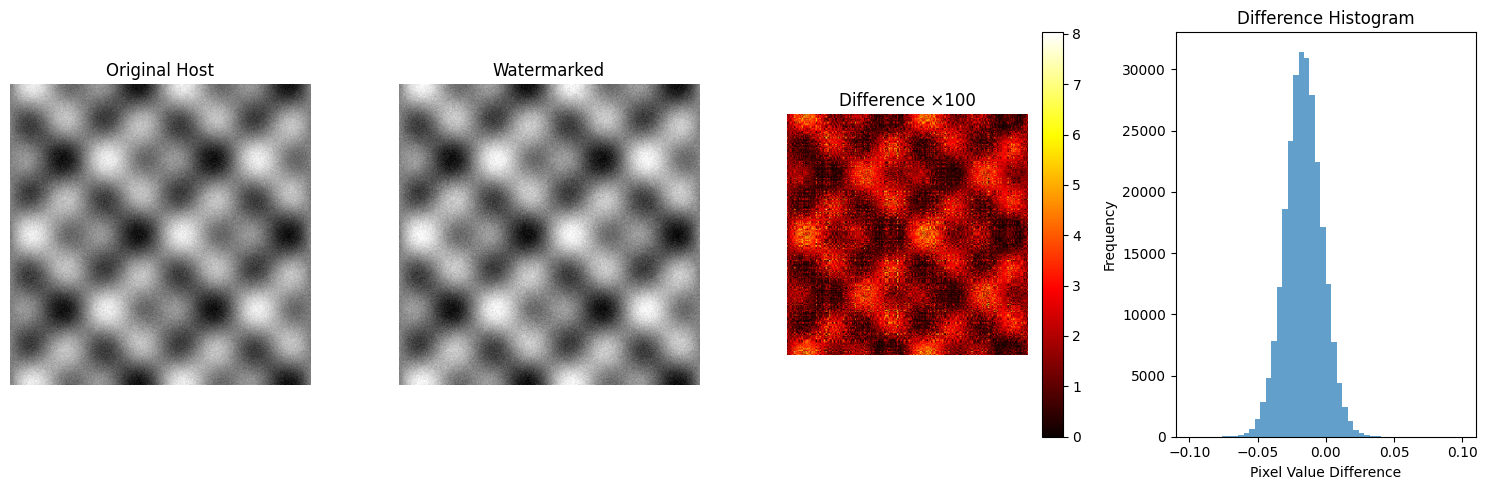


2. ✅ VERIFY WATERMARKED IMAGE (Should PASS)
🔍 Starting authenticity verification...
   🔍 Testing against 64b839f0ab953949: Similarity (Correlation) = 0.9963

🔍 AUTHENTICITY VERIFICATION REPORT
🕒 Time: 2025-10-20T21:56:09.422175
📊 Similarity (Correlation): 0.9963
🎯 Confidence: VERY HIGH
🔐 Status: ✅ AUTHENTIC
📄 Copyright ID Found: 64b839f0ab953949
👤 Registered Owner: Test Company
👤 Expected Owner Match: CONFIRMED
   ➡️ Expected: AUTHENTIC, VERY HIGH/HIGH Confidence. Result: AUTHENTIC, VERY HIGH

3. ❌ VERIFY ORIGINAL IMAGE (Should FAIL)
🔍 Starting authenticity verification...
   🔍 Testing against 64b839f0ab953949: Similarity (Correlation) = 0.0000

🔍 AUTHENTICITY VERIFICATION REPORT
🕒 Time: 2025-10-20T21:56:09.466696
📊 Similarity (Correlation): 0.0000
🎯 Confidence: VERY LOW
🔐 Status: ❌ SUSPICIOUS
📄 Copyright ID Found: 64b839f0ab953949
👤 Registered Owner: Test Company
👤 Expected Owner Match: CONFIRMED
   ➡️ Expected: SUSPICIOUS, VERY LOW Confidence. Result: SUSPICIOUS, VERY LOW

4. ❌ VERI

In [5]:
def comprehensive_test():
    """Run comprehensive test of the fixed system"""

    # Use a slightly higher alpha for potentially better robustness, adjust as needed
    system = FixedWatermarkingSystem(base_alpha=0.15, wavelet='haar')

    print("\n🎯 COMPREHENSIVE SYSTEM TEST")
    print("="*60)

    # Test 1: Register copyright
    print("\n1. 📝 REGISTER COPYRIGHT")
    watermarked, copyright_info = system.register_copyright(
        host_path, 'Test Company', 'test@company.com', 'All rights reserved'
    )

    if watermarked is None:
        print("   ❌ Registration failed. Cannot continue test.")
        return None


    # Save watermarked image for verification test
    watermarked_path = 'test_watermarked.jpg'
    Image.fromarray((watermarked * 255).astype(np.uint8)).save(watermarked_path)

    # Display embedding results
    original = system.preprocess_image(host_path)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Host')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(watermarked, cmap='gray')
    plt.title('Watermarked')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    # Amplify difference more for visibility if needed
    diff = np.abs(original - watermarked) * 100
    plt.imshow(diff, cmap='hot', vmin=0, vmax=diff.max()) # Set vmin/vmax
    plt.title('Difference ×100')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.hist((original - watermarked).flatten(), bins=50, range=(-0.1, 0.1), alpha=0.7) # Adjust range if needed
    plt.title('Difference Histogram')
    plt.xlabel('Pixel Value Difference')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # --- Test 2: Verify watermarked image (Should now PASS with high correlation) ---
    print("\n2. ✅ VERIFY WATERMARKED IMAGE (Should PASS)")
    report1, match1, _ = system.verify_authenticity(watermarked_path, 'Test Company')
    system.display_verification_report(report1)
    print(f"   ➡️ Expected: AUTHENTIC, VERY HIGH/HIGH Confidence. Result: {report1['authentication_status']}, {report1['confidence_level']}")

    # --- Test 3: Verify original image (Should now FAIL with low correlation) ---
    print("\n3. ❌ VERIFY ORIGINAL IMAGE (Should FAIL)")
    report2, match2, _ = system.verify_authenticity(host_path, 'Test Company')
    system.display_verification_report(report2)
    print(f"   ➡️ Expected: SUSPICIOUS, VERY LOW Confidence. Result: {report2['authentication_status']}, {report2['confidence_level']}")


    # --- Test 4: Verify different image (Should FAIL) ---
    print("\n4. ❌ VERIFY DIFFERENT IMAGE (Should FAIL)")
    # Create a different image
    different_img = np.random.rand(512, 512) * 0.5 + 0.25
    different_path = 'test_different.jpg'
    Image.fromarray((different_img * 255).astype(np.uint8)).save(different_path)
    report3, match3, _ = system.verify_authenticity(different_path, 'Test Company')
    system.display_verification_report(report3)
    print(f"   ➡️ Expected: SUSPICIOUS, VERY LOW Confidence. Result: {report3['authentication_status']}, {report3['confidence_level']}")


    # Test 5: Database summary
    print("\n5. 📊 DATABASE SUMMARY")
    system.display_database()

    # Test 6: Verification Log
    print("\n6. 📜 VERIFICATION LOG")
    system.display_verification_log()


    # Clean up temporary files
    # os.remove(watermarked_path)
    # os.remove(different_path)
    # os.remove(host_path) # remove original test host if desired


    return system

# Run comprehensive test
tested_system = comprehensive_test()

In [6]:
def test_with_real_images(system): # Pass the tested system in
    """Test with more realistic scenarios using the corrected system"""
    if system is None:
         print("\n🔬 ADVANCED TESTING - Skipped due to registration failure.")
         return

    print("\n🔬 ADVANCED TESTING")
    print("="*50)

    print("1. Testing robustness against common attacks...")

    # Load the watermarked image path
    watermarked_path = 'test_watermarked.jpg'
    try:
         watermarked_img_orig = system.preprocess_image(watermarked_path)
    except Exception as e:
         print(f"   ❌ Could not load watermarked image for robustness test: {e}")
         return


    # Define attacks
    attacks = {
        'Gaussian Noise (0.01 std)': lambda img: np.clip(img + np.random.normal(0, 0.01, img.shape), 0, 1),
        'Brightness +5%': lambda img: np.clip(img * 1.05, 0, 1),
        'Contrast +10%': lambda img: np.clip((img - 0.5) * 1.1 + 0.5, 0, 1),
        # Simulate JPEG by saving and reloading with quality loss
        'JPEG Compression (Q=75)': lambda img: save_reload_jpeg(img, 'temp_jpeg_attack.jpg', quality=75),
        # Add slight rotation (e.g., 1 degree) - requires scipy.ndimage
        # 'Rotation (1 deg)': lambda img: rotate_image(img, 1),
        # Add slight scaling (e.g., resize down and up)
        # 'Scaling (95%)': lambda img: scale_image(img, 0.95),
    }

    # Helper for JPEG
    def save_reload_jpeg(img, path, quality=75):
        pil_img = Image.fromarray((np.clip(img, 0, 1) * 255).astype(np.uint8))
        pil_img.save(path, 'JPEG', quality=quality)
        reloaded_pil = Image.open(path).convert('L')
        reloaded_np = np.array(reloaded_pil).astype(np.float64) / 255.0
        return reloaded_np

    # Helper for Rotation (optional, needs scipy)
    # from scipy.ndimage import rotate
    # def rotate_image(img, angle):
    #     return np.clip(rotate(img, angle, reshape=False, mode='nearest'), 0, 1)

    # Helper for Scaling (optional)
    # def scale_image(img, factor):
    #     h, w = img.shape
    #     new_h, new_w = int(h * factor), int(w * factor)
    #     scaled_down = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    #     scaled_up = cv2.resize(scaled_down, (w, h), interpolation=cv2.INTER_LINEAR)
    #     return np.clip(scaled_up, 0, 1)


    print("\n🛡️ ROBUSTNESS TEST RESULTS (Correlation Score):")
    results = {}
    for attack_name, attack_func in attacks.items():
        print(f"\n   Applying Attack: {attack_name}")
        try:
            attacked_img = attack_func(watermarked_img_orig.copy())
            temp_path = f'test_attacked_{attack_name.replace(" ", "_").replace("%","").replace("=","").replace("(","").replace(")","").replace("+","")}.jpg'

            # Save the attacked image before verifying
            Image.fromarray((attacked_img * 255).astype(np.uint8)).save(temp_path)

            # Verify the attacked image
            report, _, _ = system.verify_authenticity(temp_path)
            similarity = report['similarity_score']
            status = report['authentication_status']
            results[attack_name] = {'similarity': similarity, 'status': status}

            print(f"      ➡️ Similarity = {similarity:.4f}, Status = {status}")

            # Optional: Display attacked image vs original watermarked
            # plt.figure(figsize=(8, 4))
            # plt.subplot(1, 2, 1)
            # plt.imshow(watermarked_img_orig, cmap='gray')
            # plt.title('Watermarked (Original)')
            # plt.axis('off')
            # plt.subplot(1, 2, 2)
            # plt.imshow(attacked_img, cmap='gray')
            # plt.title(f'Attacked ({attack_name})')
            # plt.axis('off')
            # plt.show()

            # Clean up temp file
            os.remove(temp_path)

        except Exception as e:
            print(f"      ❌ Attack Application/Verification Failed: {e}")
            results[attack_name] = {'similarity': 'N/A', 'status': 'ERROR'}


    print("\n   --- Robustness Summary ---")
    for name, res in results.items():
         print(f"      {name:<25}: Sim={res['similarity']}, Status={res['status']}")

    print("="*50)


# Run advanced tests using the system from the comprehensive test
if 'tested_system' in locals() and tested_system is not None:
     test_with_real_images(tested_system)
else:
     print("\nSkipping advanced testing as the system object is not available.")


🔬 ADVANCED TESTING
1. Testing robustness against common attacks...

🛡️ ROBUSTNESS TEST RESULTS (Correlation Score):

   Applying Attack: Gaussian Noise (0.01 std)
🔍 Starting authenticity verification...
   🔍 Testing against 64b839f0ab953949: Similarity (Correlation) = 0.9943
      ➡️ Similarity = 0.9943, Status = AUTHENTIC

   Applying Attack: Brightness +5%
🔍 Starting authenticity verification...
   🔍 Testing against 64b839f0ab953949: Similarity (Correlation) = 0.9531
      ➡️ Similarity = 0.9531, Status = AUTHENTIC

   Applying Attack: Contrast +10%
🔍 Starting authenticity verification...
   🔍 Testing against 64b839f0ab953949: Similarity (Correlation) = 0.8326
      ➡️ Similarity = 0.8326, Status = AUTHENTIC

   Applying Attack: JPEG Compression (Q=75)
🔍 Starting authenticity verification...
   🔍 Testing against 64b839f0ab953949: Similarity (Correlation) = 0.9967
      ➡️ Similarity = 0.9967, Status = AUTHENTIC

   --- Robustness Summary ---
      Gaussian Noise (0.01 std): Sim=0.99